In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 14.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=6e46c354d0183ae8a21ac2b6ca91585dede9268c305946d825cd4a7598edc662
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


Task1

In [ ]:
import random
from pyspark.sql.functions import udf
from pyspark.sql import Row
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import mean, stddev, round as _round

1 Create a spark session

In [ ]:
spark_session = SparkSession.builder.getOrCreate()


2 Read the dataset into the dataframe.

In [ ]:
users_df = spark_session.read.csv('/content/sample_data/bestsellers with categories.csv', header=True)
users_df.show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

3 Using only RDD will calculate the average price of all books with a rating higher than 4.7

In [ ]:
users_df.filter(users_df['User Rating'] > 4.7).agg({'Price': 'mean'}).show()

+-----------------+
|       avg(Price)|
+-----------------+
|10.69832402234637|
+-----------------+



4 Construct a histogram of the distribution of reviews (Reviews column).

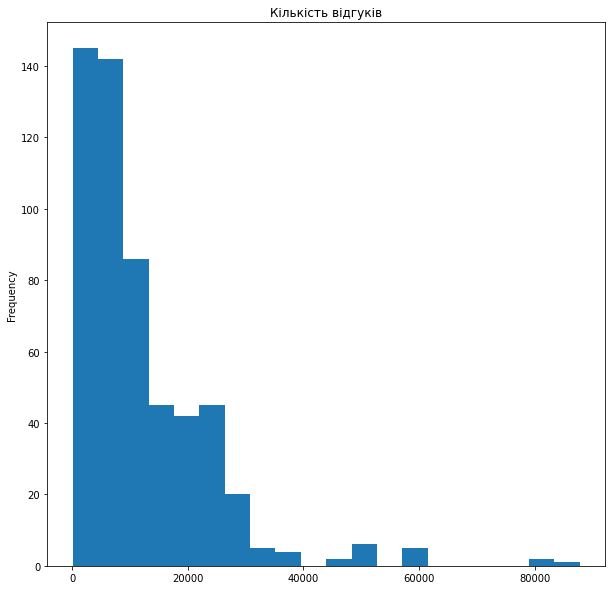

In [ ]:
import matplotlib.pyplot as plt

books_pd = users_df.toPandas()
books_pd['Reviews'] = books_pd['Reviews'].astype(int)
books_pd['Reviews'].plot(kind='hist', bins=20, figsize=(10, 10))
plt.title('Кількість відгуків')
plt.show()

5 Build a correlation matrix for the "User Rating", "Reviews" and "Price" columns.

In [ ]:
books_pd['User Rating'] = books_pd['User Rating'].astype(float)
books_pd['Price'] = books_pd['Price'].astype(int)
cor = books_pd.loc[:, ['User Rating', 'Reviews', 'Price']].corr()
cor

,User Rating,Reviews,Price
User Rating,1.000000,-0.001729,-0.133086
Reviews,-0.001729,1.000000,-0.109182
Price,-0.133086,-0.109182,1.000000


6 Using the seaborn library, construct pair plots of the "User Rating", "Reviews" and "Price" columns.

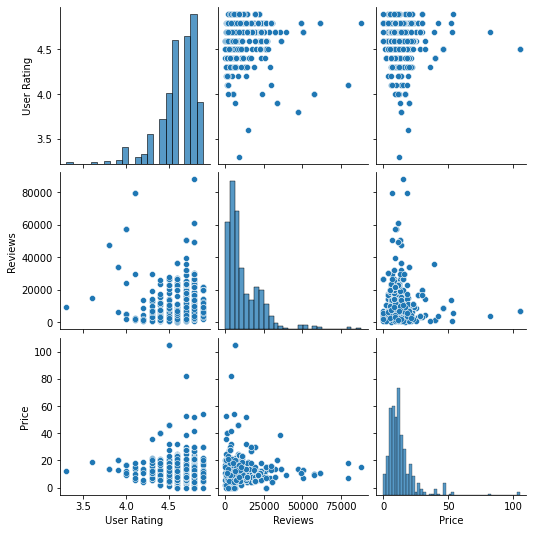

In [ ]:
sns.pairplot((books_pd.loc[:, ['User Rating', 'Reviews', 'Price']]))

Task 2

1 Find the author with the highest rating.

In [ ]:
users_df.withColumnRenamed('User Rating', 'User_Rating').createOrReplaceTempView('Books')
spark_session.sql('Select * From Books').show()

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User_Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

In [ ]:
spark_session.sql('Select Author, avg(User_Rating) as avg_rat From Books Group By Author Order By avg_rat DESC Limit 1').show()

+----------+-------+
|    Author|avg_rat|
+----------+-------+
|Jill Twiss|    4.9|
+----------+-------+




2 Find the three authors with the lowest rating.

In [ ]:
spark_session.sql('Select Author, avg(User_Rating) as avg_rat From Books Group By Author Order By avg_rat Limit 3').show()

+--------------+-------+
|        Author|avg_rat|
+--------------+-------+
|   Donna Tartt|    3.9|
| Gillian Flynn|    4.0|
|Muriel Barbery|    4.0|
+--------------+-------+




3 Determine which author received the largest number of reviews.

In [ ]:
spark_session.sql('Select Author, sum(Reviews) as rev From Books Group By Author Order By rev DESC Limit 1').show()

+---------------+--------+
|         Author|     rev|
+---------------+--------+
|Suzanne Collins|278329.0|
+---------------+--------+




4 Determine which author wrote the largest number of books for the entire available period.

In [ ]:
spark_session.sql('Select Author, count(Author) as books From Books Group By Author Order By books desc Limit 1').show()

+-----------+-----+
|     Author|books|
+-----------+-----+
|Jeff Kinney|   12|
+-----------+-----+




5 Determine which book of the genre "Fiction" has the lowest rating.

In [ ]:
spark_session.sql('Select Name, User_Rating From Books Where Genre = "Fiction" Order By User_Rating Limit 1').show()

+------------------+-----------+
|              Name|User_Rating|
+------------------+-----------+
|The Casual Vacancy|        3.3|
+------------------+-----------+



6 Determine which book in the "Non Fiction" genre has the highest rating.

In [ ]:
spark_session.sql('Select Name, User_Rating From Books Where Genre = "Non Fiction" Order By User_Rating Limit 1').show()

+-------------------+-----------+
|               Name|User_Rating|
+-------------------+-----------+
|StrengthsFinder 2.0|          4|
+-------------------+-----------+



Task 3

Construct a histogram of the average number of reviews by year. In the form of a separate histogram, visualize the number of books of the genre "Fiction" and "Non Fiction" for the entire available period.

In [ ]:
books = users_df.groupBy('Year').agg({'Reviews': 'mean'}).orderBy('Year').toPandas()

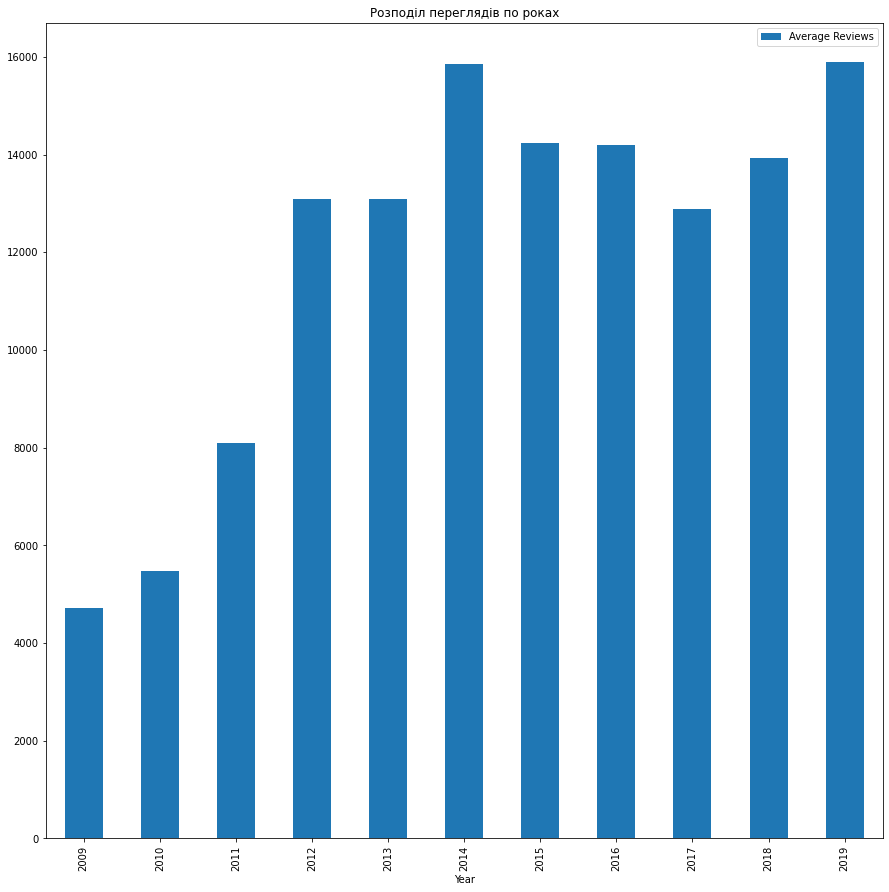

In [ ]:
books.plot(kind='bar', x='Year', y='avg(Reviews)', figsize=(15, 15), label='Average Reviews')
plt.title('Розподіл переглядів по роках')
plt.show()